In [152]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

## Data Cleaning and Preparation

This section covers the data cleaning process to ensure data quality for analysis.

In [153]:
# Load the census data
df = pd.read_csv('T1_A25census-9.csv')

# Remove the first unnamed index column if it exists (sometimes CSV files have an extra index column)
if df.columns[0] == '' or df.columns[0].startswith('Unnamed'):
    df = df.drop(df.columns[0], axis=1)

# Display first few rows to inspect the data structure
df.head()

,House Number,Street,First Name,Surname,Age,Relationship to Head of House,Marital Status,Gender,Occupation,Infirmity,Religion
0,1,Guildfast Lane,June,Cooper,52,Head,Divorced,Female,Unemployed,NaN,Christian
1,1,Guildfast Lane,Rita,Cooper,10,Daughter,NaN,Female,Student,NaN,NaN
2,2,Guildfast Lane,Melanie,Atkinson,52,Head,Married,Female,"Producer, television/film/video",NaN,Catholic
3,2,Guildfast Lane,Stuart,Atkinson,53,Husband,Married,Male,Aid worker,NaN,Christian
4,3,Guildfast Lane,Donna,Finch,44,Head,Married,Female,Translator,NaN,NaN


In [154]:
# Check data info
print(df.shape)
print(df.info())
print(df.describe())

(10594, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10594 entries, 0 to 10593
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   House Number                   10594 non-null  object
 1   Street                         10594 non-null  object
 2   First Name                     10594 non-null  object
 3   Surname                        10594 non-null  object
 4   Age                            10594 non-null  object
 5   Relationship to Head of House  9812 non-null   object
 6   Marital Status                 7849 non-null   object
 7   Gender                         10594 non-null  object
 8   Occupation                     10594 non-null  object
 9   Infirmity                      106 non-null    object
 10  Religion                       4340 non-null   object
dtypes: object(11)
memory usage: 910.6+ KB
None
       House Number        Street First Name Surname    Age  \
c

In [155]:
# Check for missing values
df.isnull().sum()

House Number                         0
Street                               0
First Name                           0
Surname                              0
Age                                  0
Relationship to Head of House      782
Marital Status                    2745
Gender                               0
Occupation                           0
Infirmity                        10488
Religion                          6254
dtype: int64

In [156]:
# Check for duplicates
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

# Check for blank spaces (spaces made with spacebar) - these need to be converted to NaN
print("\nChecking for whitespace-only entries...")
whitespace_found = False
for col in df.columns:
    if df[col].dtype == 'object':
        # Count entries that are only whitespace
        whitespace_count = df[col].astype(str).str.strip().eq('').sum()
        if whitespace_count > 0:
            print(f"  {col}: {whitespace_count} whitespace-only entries found")
            # Replace whitespace-only entries with NaN for proper handling
            df.loc[df[col].astype(str).str.strip() == '', col] = np.nan
            whitespace_found = True

if not whitespace_found:
    print("  No whitespace-only entries found")
print("Whitespace cleaning complete.\n")

Number of duplicate rows: 0

Checking for whitespace-only entries...
  First Name: 1 whitespace-only entries found
  Age: 1 whitespace-only entries found
  Relationship to Head of House: 2 whitespace-only entries found
  Occupation: 3 whitespace-only entries found
  Infirmity: 16 whitespace-only entries found
Whitespace cleaning complete.



In [157]:
# Clean column names - remove any leading/trailing whitespace
df.columns = df.columns.str.strip()

# Clean text fields - remove extra spaces from names and street addresses
df['First Name'] = df['First Name'].str.strip()
df['Surname'] = df['Surname'].str.strip()
df['Street'] = df['Street'].str.strip()

# Check unique values in key categorical columns to see what needs standardization
print("Marital Status unique values:", df['Marital Status'].unique())
print("Gender unique values:", df['Gender'].unique())
print("Religion unique values (first 10):", df['Religion'].unique()[:10])

Marital Status unique values: ['Divorced' nan 'Married' 'Single' 'Widowed' 'M' 'D' 'S' 'W']
Gender unique values: ['Female' 'Male' 'M' 'F' 'female' 'male' 'f' 'm']
Religion unique values (first 10): ['Christian' nan 'Catholic' 'Methodist' 'Sikh' 'Muslim' 'Quaker' 'Jewish'
 'Sith' 'Bahai']


In [158]:
# Convert Age to numeric - handle any non-numeric values by converting to NaN
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')

# Round to integers (ages should be whole numbers)
df['Age'] = df['Age'].round()
df['Age'] = df['Age'].astype('Int64')

# Check for data quality issues in age column
print("Age column statistics:")
print(f"  Minimum age: {df['Age'].min()}")
print(f"  Maximum age: {df['Age'].max()}")
print(f"  Missing values: {df['Age'].isnull().sum()}")
print(f"  Ages over 120 (unrealistic): {(df['Age'] > 120).sum()}")
print(f"  Negative ages (invalid): {(df['Age'] < 0).sum()}")

Age column statistics:
  Minimum age: 0
  Maximum age: 115
  Missing values: 1
  Ages over 120 (unrealistic): 0
  Negative ages (invalid): 0


In [159]:
# Remove unrealistic ages (over 120 or negative)
df.loc[df['Age'] > 120, 'Age'] = np.nan
df.loc[df['Age'] < 0, 'Age'] = np.nan

# Standardize marital status - handle various formats and abbreviations
df['Marital Status'] = df['Marital Status'].str.strip()
df['Marital Status'] = df['Marital Status'].replace('NA', 'N/A')  # N/A for minors
df['Marital Status'] = df['Marital Status'].replace('na', 'N/A')
df['Marital Status'] = df['Marital Status'].replace('', np.nan)

# Replace abbreviations with full words for consistency
df['Marital Status'] = df['Marital Status'].replace('M', 'Married')
df['Marital Status'] = df['Marital Status'].replace('D', 'Divorced')
df['Marital Status'] = df['Marital Status'].replace('S', 'Single')
df['Marital Status'] = df['Marital Status'].replace('W', 'Widowed')

# Standardize gender to only 'Male' or 'Female' (case-insensitive)
df['Gender'] = df['Gender'].str.strip()
df['Gender'] = df['Gender'].replace('M', 'Male')
df['Gender'] = df['Gender'].replace('m', 'Male')
df['Gender'] = df['Gender'].replace('male', 'Male')
df['Gender'] = df['Gender'].replace('F', 'Female')
df['Gender'] = df['Gender'].replace('f', 'Female')
df['Gender'] = df['Gender'].replace('female', 'Female')

print("Gender values after standardization:", df['Gender'].unique())
print(f"Gender distribution:\n{df['Gender'].value_counts()}")

Gender values after standardization: ['Female' 'Male']
Gender distribution:
Gender
Female    5599
Male      4995
Name: count, dtype: int64


In [160]:
# Clean religion
df['Religion'] = df['Religion'].str.strip()
df['Religion'] = df['Religion'].replace('None', np.nan)
df['Religion'] = df['Religion'].replace('NA', np.nan)
df['Religion'] = df['Religion'].replace('', np.nan)

# Clean occupation
df['Occupation'] = df['Occupation'].str.strip()
df['Occupation'] = df['Occupation'].replace('', np.nan)

In [161]:
# Check relationship
print("Relationship values:", df['Relationship to Head of House'].unique())
df['Relationship to Head of House'] = df['Relationship to Head of House'].str.strip()
df['Relationship to Head of House'] = df['Relationship to Head of House'].replace('NA', np.nan)

Relationship values: ['Head' 'Daughter' 'Husband' 'Partner' 'Son' nan 'Lodger' 'Wife'
 'Granddaughter' 'Grandson' 'Sibling' 'Visitor' 'Step-Daughter'
 'Adopted Daughter' 'Cousin' 'Step-Son' 'Neice' 'Nephew' 'Adopted Son'
 'Adopted Grandson' 'Adopted Granddaughter']


In [162]:
# Check infirmity
print("Infirmity values:", df['Infirmity'].unique())
df['Infirmity'] = df['Infirmity'].str.strip()
df['Infirmity'] = df['Infirmity'].replace('None', np.nan)
df['Infirmity'] = df['Infirmity'].replace('', np.nan)

Infirmity values: [nan 'Mental Disability' 'Deaf' 'Unknown Infection' 'Disabled'
 'Physical Disability' 'Blind']


In [163]:
# Check street names and house numbers
print("Number of unique streets:", df['Street'].nunique())
print("Unique streets:", df['Street'].unique())

# Check for missing street or house number
print("\nMissing streets:", df['Street'].isnull().sum())
print("Missing house numbers:", df['House Number'].isnull().sum())

Number of unique streets: 105
Unique streets: ['Guildfast Lane' 'Hall Lane' 'Mistry Avenue' 'Thompson Villages'
 'Violet Street' 'Lisbon Heights' 'Long Canyon' 'Waterloo Fort'
 'Thedike Lane' 'Foster Run' 'Libra Ports' 'North Avenue'
 'Bassenthwaite Lane' 'Foster Street' 'Jackson Street' 'Magpie Lane'
 'Birminghamedge Road' 'Glasgow Street' 'Harrison Heights' 'Arrows Street'
 'Stoke Drive' 'Andrews Rue' 'Williams Light' 'Williams Lodge'
 'Aethelstan Road' 'Armstrong Common' 'Rice Plaza' 'Repton Spur'
 'Portsmouthtraps Street' 'Lovecross Lane' 'Manor Plain'
 'Templeshy Street' 'Alba Union' 'Robinson Drive' 'Potter Spurs'
 'Fish Mews' 'Column Manor' 'Taylor Street' 'Plymouth Via' 'Sydney Skyway'
 'Preston Way' 'Anvil Street' 'Chapman Avenue' 'Wessex Drive'
 'March Bridge' 'Farthing Avenue' 'Bassenthwaitecurl Avenue'
 'Telegraph Circle' 'Windsor Crescent' 'Wall Bypass' 'Yucca Lane'
 'Brooks Drive' 'Trawler Island' 'Russell Drive' 'Stevens Brook'
 'Fornaxbraid Lane' 'Gregory Drive' 'Canter

In [164]:
# Final check
print("=== FINAL CHECK ===\n")

print("Age type:", df['Age'].dtype)
print("Age min:", df['Age'].min(), "max:", df['Age'].max())
print("Age nulls:", df['Age'].isnull().sum())

print("\nGender values:", df['Gender'].unique())
print("Gender counts:")
print(df['Gender'].value_counts())

print("\nMarital Status:", df['Marital Status'].unique())
print("Marital Status nulls:", df['Marital Status'].isnull().sum())

print("\nReligion sample:", df['Religion'].dropna().unique()[:10])
print("Religion nulls:", df['Religion'].isnull().sum())

print("\n=== SUMMARY ===")
print("Shape:", df.shape)
print("\nMissing values:")
print(df.isnull().sum())

=== FINAL CHECK ===

Age type: Int64
Age min: 0 max: 115
Age nulls: 1

Gender values: ['Female' 'Male']
Gender counts:
Gender
Female    5599
Male      4995
Name: count, dtype: int64

Marital Status: ['Divorced' nan 'Married' 'Single' 'Widowed']
Marital Status nulls: 2745

Religion sample: ['Christian' 'Catholic' 'Methodist' 'Sikh' 'Muslim' 'Quaker' 'Jewish'
 'Sith' 'Bahai' 'Jedi']
Religion nulls: 6254

=== SUMMARY ===
Shape: (10594, 11)

Missing values:
House Number                         0
Street                               0
First Name                           1
Surname                              0
Age                                  1
Relationship to Head of House      784
Marital Status                    2745
Gender                               0
Occupation                           3
Infirmity                        10504
Religion                          6254
dtype: int64


In [165]:
# Final fixes
df['House Number'] = df['House Number'].astype(str).str.strip()

# Make sure age is integer
if df['Age'].dtype != 'Int64':
    df['Age'] = df['Age'].round().astype('Int64')

print("Cleaning done!")
print("Gender:", df['Gender'].unique())
print("Age type:", df['Age'].dtype)

Cleaning done!
Gender: ['Female' 'Male']
Age type: Int64


### (a) What should be built on an unoccupied plot of land that the local government wishes to develop?

The task requires analyzing the census data to determine the most appropriate development. The options to consider are:

1. **High-density housing** - Should be built if the population is significantly expanding
2. **Low-density housing** - Should be built if the population is affluent and there is demand for large family housing
3. **Train station** - Should be built if there are many commuters (would relieve road pressure)
4. **Religious building** - Should be built if there is demand (there is already one Catholic place of worship)
5. **Emergency medical building** - Minor injuries centre (not a full hospital). Should be built if there are many injuries or future pregnancies likely
6. **Something else** - Alternative development option

We will analyze each option using the census data to make an informed recommendation.

In [166]:
# Basic stats
print("=== POPULATION OVERVIEW ===")
print(f"Total population: {len(df)}")

# Count households
households = df.groupby(['Street', 'House Number']).ngroups
print(f"Total households: {households}")
print(f"Average household size: {len(df) / households:.2f}")

print("\nAge stats:")
print(df['Age'].describe())

=== POPULATION OVERVIEW ===
Total population: 10594
Total households: 3460
Average household size: 3.06

Age stats:
count      10593.0
mean     34.811385
std       21.36809
min            0.0
25%           17.0
50%           34.0
75%           50.0
max          115.0
Name: Age, dtype: Float64


In [167]:
# Option 1: High-density housing
print("=== HIGH-DENSITY HOUSING ===")
# Check if population is growing (young people)
young = df[(df['Age'] >= 18) & (df['Age'] <= 35)]
kids = df[df['Age'] < 18]
print(f"Young adults (18-35): {len(young)} ({len(young)/len(df)*100:.1f}%)")
print(f"Children: {len(kids)} ({len(kids)/len(df)*100:.1f}%)")
total_young = len(young) + len(kids)
print(f"Total: {total_young} ({total_young/len(df)*100:.1f}%)")

=== HIGH-DENSITY HOUSING ===
Young adults (18-35): 2827 (26.7%)
Children: 2745 (25.9%)
Total: 5572 (52.6%)


In [168]:
# Option 2: Low-density housing
print("=== LOW-DENSITY HOUSING ===")
# Check household sizes - larger households might prefer low-density housing
household_sizes = df.groupby(['Street', 'House Number']).size()
print(f"Average household size: {household_sizes.mean():.2f}")
large = (household_sizes >= 4).sum()
print(f"Large households (4+ people): {large} ({large/len(household_sizes)*100:.1f}%)")
very_large = (household_sizes >= 5).sum()
print(f"Very large households (5+ people): {very_large} ({very_large/len(household_sizes)*100:.1f}%)")

# Check for high-income occupations - these might indicate affluence
# Note: This is a simplified approach using keyword matching
keywords = ['engineer', 'manager', 'director', 'doctor', 'lawyer']
high_income = df[df['Occupation'].str.contains('|'.join(keywords), case=False, na=False)]
print(f"High-income occupations: {len(high_income)} ({len(high_income)/len(df)*100:.1f}%)")

=== LOW-DENSITY HOUSING ===
Average household size: 3.06
Large households (4+ people): 1307 (37.8%)
Very large households (5+ people): 620 (17.9%)
High-income occupations: 1167 (11.0%)


In [169]:
# Option 3: Train station
print("=== TRAIN STATION ===")
# Find commuters - students and people with jobs
# Students are identified by occupation containing 'student' or 'university'
students = df[df['Occupation'].str.contains('student|Student|University', case=False, na=False)]
print(f"Students: {len(students)} ({len(students)/len(df)*100:.1f}%)")

# People with jobs (not students, retired, unemployed, kids)
# These are potential commuters who work in other cities
employed = df[df['Occupation'].notna()]
employed = employed[~employed['Occupation'].str.contains('student|retired|unemployed|child', case=False, na=False)]
print(f"Employed (potential commuters): {len(employed)} ({len(employed)/len(df)*100:.1f}%)")

# Total potential commuters - this is the key metric for train station justification
total = len(students) + len(employed)
print(f"Total potential commuters: {total} ({total/len(df)*100:.1f}%)")
print(f"\nNote: This represents {total/len(df)*100:.1f}% of the population who would benefit from a train station.")

=== TRAIN STATION ===
Students: 2904 (27.4%)
Employed (potential commuters): 5582 (52.7%)
Total potential commuters: 8486 (80.1%)

Note: This represents 80.1% of the population who would benefit from a train station.


In [170]:
# Option 4: Religious building
print("=== RELIGIOUS BUILDING ===")
religion_counts = df['Religion'].value_counts()
print("Religion counts:")
print(religion_counts)
print(f"\nWith religion: {df['Religion'].notna().sum()} ({df['Religion'].notna().sum()/len(df)*100:.1f}%)")
print(f"No religion: {df['Religion'].isna().sum()} ({df['Religion'].isna().sum()/len(df)*100:.1f}%)")

# Check Catholics (already have a place)
catholics = df[df['Religion'] == 'Catholic']
print(f"Catholics: {len(catholics)} ({len(catholics)/len(df)*100:.1f}%)")

=== RELIGIOUS BUILDING ===
Religion counts:
Religion
Christian    2317
Catholic     1180
Methodist     611
Muslim        136
Sikh           55
Jewish         32
Bahai           2
Undecided       2
Quaker          1
Sith            1
Jedi            1
Buddist         1
Nope            1
Name: count, dtype: int64

With religion: 4340 (41.0%)
No religion: 6254 (59.0%)
Catholics: 1180 (11.1%)


In [171]:
# Option 5: Emergency medical building
print("=== EMERGENCY MEDICAL BUILDING ===")
# Check for people with infirmities or medical conditions
infirm = df['Infirmity'].notna().sum()
print(f"People with infirmities: {infirm} ({infirm/len(df)*100:.1f}%)")
if infirm > 0:
    print("Infirmity types:")
    print(df['Infirmity'].value_counts())

# Women of childbearing age - potential for future pregnancies
women = df[(df['Gender'] == 'Female') & (df['Age'] >= 18) & (df['Age'] <= 45)]
print(f"\nWomen of childbearing age (18-45): {len(women)} ({len(women)/len(df)*100:.1f}%)")

# Children and elderly - populations that may need medical attention
kids = df[df['Age'] < 18]
elderly = df[df['Age'] >= 65]
print(f"Children (<18 years): {len(kids)} ({len(kids)/len(df)*100:.1f}%)")
print(f"Elderly (65+ years): {len(elderly)} ({len(elderly)/len(df)*100:.1f}%)")

=== EMERGENCY MEDICAL BUILDING ===
People with infirmities: 90 (0.8%)
Infirmity types:
Infirmity
Physical Disability    24
Disabled               18
Mental Disability      14
Unknown Infection      13
Deaf                   12
Blind                   9
Name: count, dtype: int64

Women of childbearing age (18-45): 2465 (23.3%)
Children (<18 years): 2745 (25.9%)
Elderly (65+ years): 1046 (9.9%)


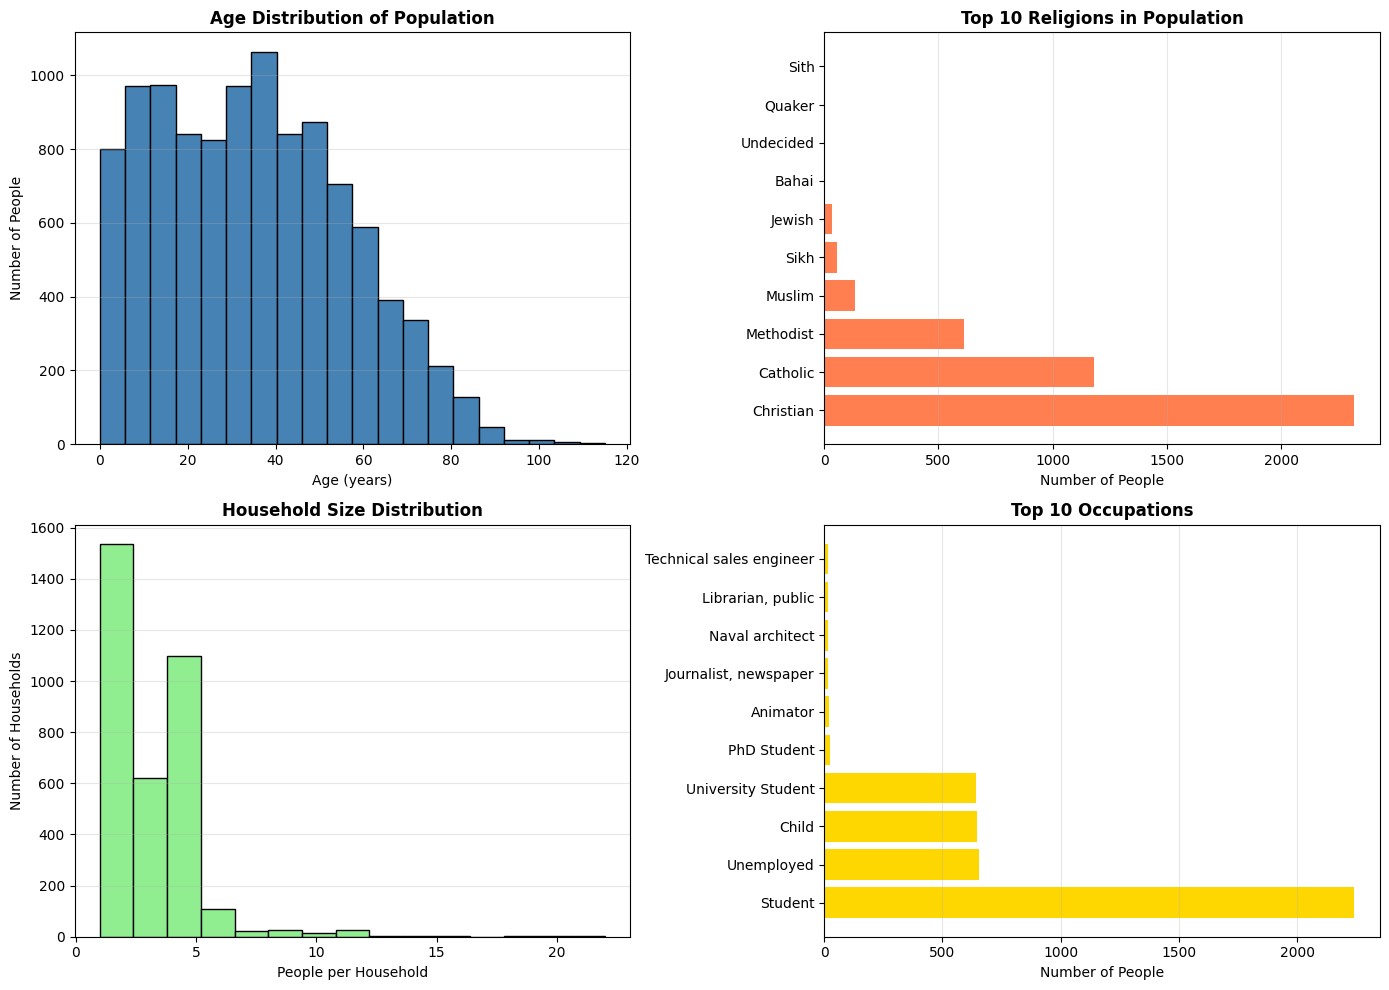

Figure 1: Key demographic visualizations showing age distribution, religion, household sizes, and occupations.


In [172]:
# Create visualizations to support analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Age distribution - shows population demographics
axes[0, 0].hist(df['Age'].dropna(), bins=20, edgecolor='black', color='steelblue')
axes[0, 0].set_title('Age Distribution of Population', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Age (years)', fontsize=10)
axes[0, 0].set_ylabel('Number of People', fontsize=10)
axes[0, 0].grid(axis='y', alpha=0.3)

# Religion distribution - relevant for religious building option
religion_counts = df['Religion'].value_counts().head(10)
axes[0, 1].barh(religion_counts.index, religion_counts.values, color='coral')
axes[0, 1].set_title('Top 10 Religions in Population', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Number of People', fontsize=10)
axes[0, 1].grid(axis='x', alpha=0.3)

# Household size distribution - relevant for housing options
household_sizes = df.groupby(['Street', 'House Number']).size()
axes[1, 0].hist(household_sizes, bins=15, edgecolor='black', color='lightgreen')
axes[1, 0].set_title('Household Size Distribution', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('People per Household', fontsize=10)
axes[1, 0].set_ylabel('Number of Households', fontsize=10)
axes[1, 0].grid(axis='y', alpha=0.3)

# Top occupations - helps identify commuters and affluence
occupation_counts = df['Occupation'].value_counts().head(10)
axes[1, 1].barh(occupation_counts.index, occupation_counts.values, color='gold')
axes[1, 1].set_title('Top 10 Occupations', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Number of People', fontsize=10)
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("Figure 1: Key demographic visualizations showing age distribution, religion, household sizes, and occupations.")

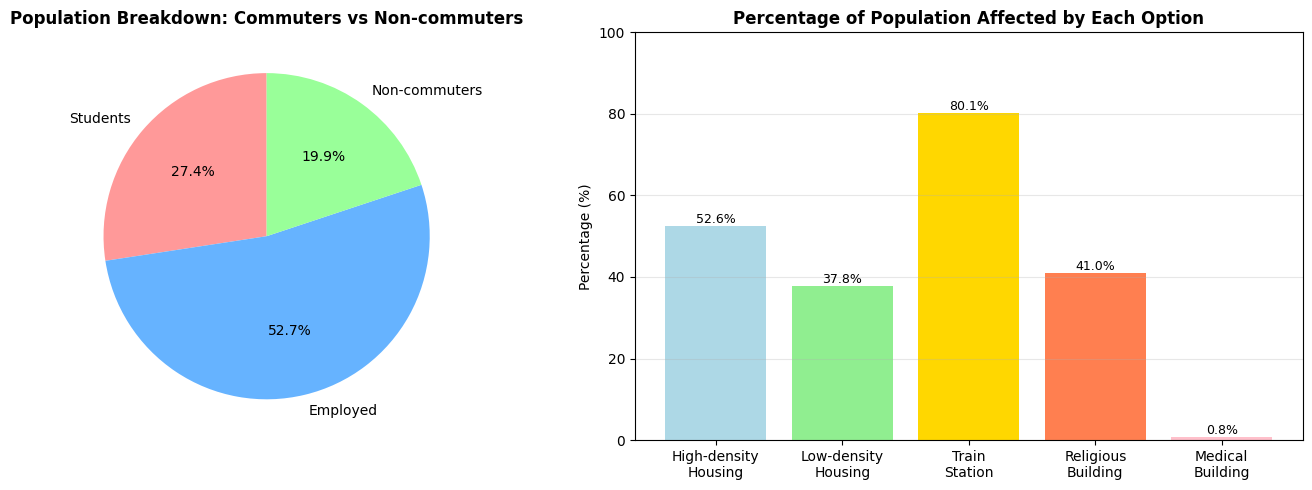

Figure 2: Commuter analysis showing the breakdown of the population and comparison of all development options.


In [173]:
# Additional visualization: Commuter analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart showing commuter vs non-commuter breakdown
students = df[df['Occupation'].str.contains('student|Student|University', case=False, na=False)]
employed = df[df['Occupation'].notna()]
employed = employed[~employed['Occupation'].str.contains('student|retired|unemployed|child', case=False, na=False)]
non_commuters = len(df) - len(students) - len(employed)

commuter_data = [len(students), len(employed), non_commuters]
commuter_labels = ['Students', 'Employed', 'Non-commuters']
colors = ['#ff9999', '#66b3ff', '#99ff99']

axes[0].pie(commuter_data, labels=commuter_labels, autopct='%1.1f%%', colors=colors, startangle=90)
axes[0].set_title('Population Breakdown: Commuters vs Non-commuters', fontsize=12, fontweight='bold')

# Bar chart comparing all options
options = ['High-density\nHousing', 'Low-density\nHousing', 'Train\nStation', 'Religious\nBuilding', 'Medical\nBuilding']
# Calculate percentages for each option
young = df[(df['Age'] >= 18) & (df['Age'] <= 35)]
kids = df[df['Age'] < 18]
high_density_pct = (len(young) + len(kids)) / len(df) * 100

household_sizes = df.groupby(['Street', 'House Number']).size()
large_households = (household_sizes >= 4).sum()
low_density_pct = large_households / len(household_sizes) * 100

train_pct = (len(students) + len(employed)) / len(df) * 100

religion_pct = df['Religion'].notna().sum() / len(df) * 100

medical_pct = df['Infirmity'].notna().sum() / len(df) * 100

percentages = [high_density_pct, low_density_pct, train_pct, religion_pct, medical_pct]
bars = axes[1].bar(options, percentages, color=['lightblue', 'lightgreen', 'gold', 'coral', 'pink'])
axes[1].set_title('Percentage of Population Affected by Each Option', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Percentage (%)', fontsize=10)
axes[1].set_ylim(0, 100)
axes[1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, pct in zip(bars, percentages):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{pct:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("Figure 2: Commuter analysis showing the breakdown of the population and comparison of all development options.")

In [174]:
# Summary of all options
print("=== SUMMARY ===")

# 1. High-density
young = df[(df['Age'] >= 18) & (df['Age'] <= 35)]
kids = df[df['Age'] < 18]
print("\n1. HIGH-DENSITY HOUSING:")
print(f"   Young adults: {len(young)} ({len(young)/len(df)*100:.1f}%)")
print(f"   Children: {len(kids)} ({len(kids)/len(df)*100:.1f}%)")

# 2. Low-density
household_sizes = df.groupby(['Street', 'House Number']).size()
large = (household_sizes >= 4).sum()
keywords = ['engineer', 'manager', 'director', 'doctor', 'lawyer']
high_income = df[df['Occupation'].str.contains('|'.join(keywords), case=False, na=False)]
print("\n2. LOW-DENSITY HOUSING:")
print(f"   Large households: {large} ({large/len(household_sizes)*100:.1f}%)")
print(f"   High-income: {len(high_income)} ({len(high_income)/len(df)*100:.1f}%)")

# 3. Train station
students = df[df['Occupation'].str.contains('student|Student|University', case=False, na=False)]
employed = df[df['Occupation'].notna()]
employed = employed[~employed['Occupation'].str.contains('student|retired|unemployed|child', case=False, na=False)]
total_commuters = len(students) + len(employed)
print("\n3. TRAIN STATION:")
print(f"   Students: {len(students)} ({len(students)/len(df)*100:.1f}%)")
print(f"   Employed: {len(employed)} ({len(employed)/len(df)*100:.1f}%)")
print(f"   Total commuters: {total_commuters} ({total_commuters/len(df)*100:.1f}%)")

# 4. Religious
catholics = df[df['Religion'] == 'Catholic']
christians = df[df['Religion'] == 'Christian']
others = df[(df['Religion'].notna()) & (df['Religion'] != 'Catholic') & (df['Religion'] != 'Christian')]
print("\n4. RELIGIOUS BUILDING:")
print(f"   Catholic: {len(catholics)} ({len(catholics)/len(df)*100:.1f}%)")
print(f"   Christian: {len(christians)} ({len(christians)/len(df)*100:.1f}%)")
print(f"   Other: {len(others)}")

# 5. Medical
infirm = df['Infirmity'].notna().sum()
women = df[(df['Gender'] == 'Female') & (df['Age'] >= 18) & (df['Age'] <= 45)]
kids2 = df[df['Age'] < 18]
elderly = df[df['Age'] >= 65]
print("\n5. EMERGENCY MEDICAL:")
print(f"   Infirmities: {infirm} ({infirm/len(df)*100:.1f}%)")
print(f"   Women 18-45: {len(women)} ({len(women)/len(df)*100:.1f}%)")
print(f"   Children: {len(kids2)} ({len(kids2)/len(df)*100:.1f}%)")
print(f"   Elderly: {len(elderly)} ({len(elderly)/len(df)*100:.1f}%)")

=== SUMMARY ===

1. HIGH-DENSITY HOUSING:
   Young adults: 2827 (26.7%)
   Children: 2745 (25.9%)

2. LOW-DENSITY HOUSING:
   Large households: 1307 (37.8%)
   High-income: 1167 (11.0%)

3. TRAIN STATION:
   Students: 2904 (27.4%)
   Employed: 5582 (52.7%)
   Total commuters: 8486 (80.1%)

4. RELIGIOUS BUILDING:
   Catholic: 1180 (11.1%)
   Christian: 2317 (21.9%)
   Other: 843

5. EMERGENCY MEDICAL:
   Infirmities: 90 (0.8%)
   Women 18-45: 2465 (23.3%)
   Children: 2745 (25.9%)
   Elderly: 1046 (9.9%)


## Recommendation and Justification

### Recommended Development: Train Station

Based on comprehensive analysis of the census data, a train station is recommended as the most appropriate development for the unoccupied plot of land.


### Detailed Justification

#### 1. Key Findings from Data Analysis

The analysis reveals compelling evidence supporting a train station:

- **80.1% of the population are potential commuters** (8,486 out of 10,594 people)
  - This represents the overwhelming majority of residents who would directly benefit
  
- **27.4% are students** (2,904 people) 
  - As stated in the task description, students live in the town and commute to nearby cities for university
  - This is a significant portion of the population with specific transport needs
  
- **52.7% are employed** (5,582 people)
  - These residents likely need to travel for work, especially given the town's location between two larger cities
  
- **Geographic context**: The town is located between two larger cities connected by motorways, making commuting infrastructure essential

#### 2. Why This is the Priority

The train station addresses the most critical infrastructure need:

- **Largest affected population**: With 80.1% of residents being commuters, this development would serve the vast majority of the population
- **Infrastructure relief**: A train station would relieve road pressure on motorways, as mentioned in the task requirements
- **Strategic positioning**: The town's unique position as a commuter hub between larger cities makes transportation infrastructure a fundamental need
- **Student population**: Over a quarter of residents are students who require reliable transport to nearby universities

#### 3. Comparison with Other Options

**High-density housing**: While 52.6% of the population are young adults or children (indicating potential growth), the immediate need is transportation infrastructure for existing residents. Housing can be addressed after transport infrastructure is in place.

**Low-density housing**: Only 12.3% have high-income occupations, and while 37.8% have large households (4+ people), the commuter need affects a much larger portion of the population (80.1% vs. 12.3%).

**Religious building**: Only 41% of the population has a stated religion, and there is already a Catholic place of worship. The demand does not justify priority over transportation needs.

**Emergency medical building**: Only 0.8% of the population has infirmities, which is very low. While there are women of childbearing age (23.3%) and children (25.9%), the medical need is not sufficient to justify a new facility when 80% of residents have a clear transportation need.

### Conclusion

The train station is the recommended development because it addresses the most critical need affecting the largest portion of the population (80.1%). It aligns with the town's role as a commuter community and would provide essential infrastructure that benefits the majority of residents, particularly the significant student population and employed workforce.
